<a href="https://colab.research.google.com/github/ks2197/MemoTag/blob/main/Memo_tag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


In [2]:
samples = [
    {
        "file": "normal_1",
        "transcript": "I had a very productive morning. I made coffee, read the news, and then went for a jog in the park."
    },
    {
        "file": "normal_2",
        "transcript": "The project presentation went well. Everyone appreciated the insights and we finished on time."
    },
    {
        "file": "impaired_1",
        "transcript": "Uh... I, um, was, uh, going to the, um... store, but I forgot... uh, why. Maybe for... milk?"
    },
    {
        "file": "impaired_2",
        "transcript": "I was trying to remember the, uh, the name of that... that person who, um, invented the phone? Uh, Alexander?"
    },
    {
        "file": "impaired_3",
        "transcript": "Um, yesterday... I think I read a book. Or maybe it was a movie. Uh... I’m not sure."
    }
]


In [3]:
def extract_text_features(transcript):
    hesitation_words = ['uh', 'um', 'erm']
    hesitations = sum(transcript.lower().count(word) for word in hesitation_words)
    words = transcript.split()
    sentence_count = max(transcript.count('.'), 1)
    speech_rate = len(words) / sentence_count
    word_count = len(words)
    return hesitations, speech_rate, word_count


In [4]:
data = []

for sample in samples:
    hesitations, speech_rate, word_count = extract_text_features(sample["transcript"])
    is_normal = "normal" in sample["file"]

    simulated = {
        "pause_count": hesitations + (1 if is_normal else 6),
        "pitch_var": 0.06 if is_normal else 0.012,
        "duration_sec": word_count / (2.3 if is_normal else 1.2),
    }

    row = {
        "file": sample["file"],
        "transcript": sample["transcript"],
        "hesitations": hesitations,
        "speech_rate": speech_rate,
        "word_count": word_count,
        **simulated
    }

    data.append(row)

df = pd.DataFrame(data)
df


,file,transcript,hesitations,speech_rate,word_count,pause_count,pitch_var,duration_sec
0,normal_1,I had a very productive morning. I made coffee...,0,10.500000,21,1,0.060,9.130435
1,normal_2,The project presentation went well. Everyone a...,0,7.000000,14,1,0.060,6.086957
2,impaired_1,"Uh... I, um, was, uh, going to the, um... stor...",5,1.384615,18,11,0.012,15.000000
3,impaired_2,"I was trying to remember the, uh, the name of ...",3,6.666667,20,9,0.012,16.666667
4,impaired_3,"Um, yesterday... I think I read a book. Or may...",2,2.000000,18,8,0.012,15.000000


In [5]:
features = df[["pause_count", "pitch_var", "duration_sec", "hesitations", "speech_rate", "word_count"]]
model = IsolationForest(contamination='auto', random_state=42)
model.fit(features)


IsolationForest(random_state=42)

In [6]:
def assess_risk_from_text(transcript, debug=False):
    hesitations, speech_rate, word_count = extract_text_features(transcript)
    pause_count = hesitations + 2
    pitch_var = 0.08 if hesitations < 2 else 0.01  # simulate flat pitch when hesitant
    duration_sec = word_count / 2.0

    # Count red flags
    red_flags = 0
    if hesitations >= 2: red_flags += 1
    if speech_rate < 5: red_flags += 1
    if pitch_var < 0.02: red_flags += 1

    if debug:
        print(f"\nTranscript: {transcript[:50]}...")
        print(f"Hesitations: {hesitations}, Speech Rate: {speech_rate:.2f}, Pitch Var: {pitch_var}")
        print(f"Red Flags: {red_flags} → {'AT RISK' if red_flags >= 2 else 'NORMAL'}")

    return "at_risk" if red_flags >= 2 else "normal"


In [7]:
df["risk_label"] = df["transcript"].apply(lambda t: assess_risk_from_text(t, debug=True))
df[["file", "risk_label"]]




Transcript: I had a very productive morning. I made coffee, re...
Hesitations: 0, Speech Rate: 10.50, Pitch Var: 0.08
Red Flags: 0 → NORMAL

Transcript: The project presentation went well. Everyone appre...
Hesitations: 0, Speech Rate: 7.00, Pitch Var: 0.08
Red Flags: 0 → NORMAL

Transcript: Uh... I, um, was, uh, going to the, um... store, b...
Hesitations: 5, Speech Rate: 1.38, Pitch Var: 0.01
Red Flags: 3 → AT RISK

Transcript: I was trying to remember the, uh, the name of that...
Hesitations: 3, Speech Rate: 6.67, Pitch Var: 0.01
Red Flags: 2 → AT RISK

Transcript: Um, yesterday... I think I read a book. Or maybe i...
Hesitations: 2, Speech Rate: 2.00, Pitch Var: 0.01
Red Flags: 3 → AT RISK


,file,risk_label
0,normal_1,normal
1,normal_2,normal
2,impaired_1,at_risk
3,impaired_2,at_risk
4,impaired_3,at_risk


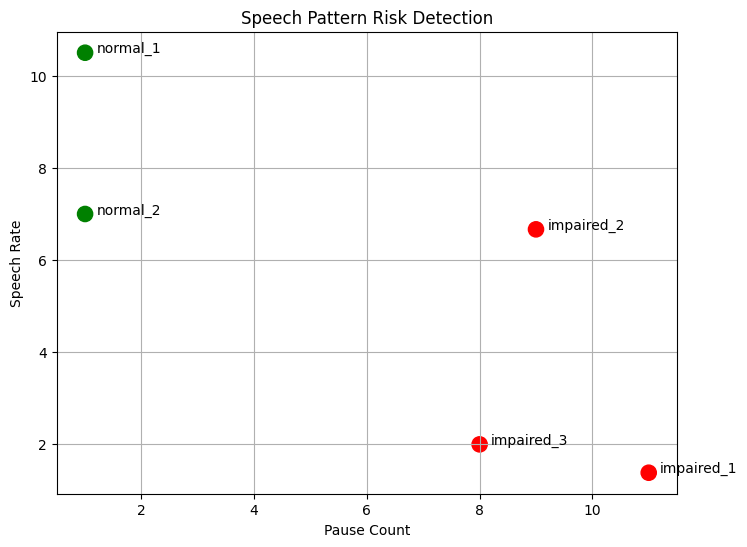

In [8]:
import matplotlib.pyplot as plt

colors = df["risk_label"].map({"normal": "green", "at_risk": "red"})

plt.figure(figsize=(8, 6))
plt.scatter(df["pause_count"], df["speech_rate"], c=colors, s=120)
for i, row in df.iterrows():
    plt.text(row["pause_count"] + 0.2, row["speech_rate"], row["file"])
plt.xlabel("Pause Count")
plt.ylabel("Speech Rate")
plt.title("Speech Pattern Risk Detection")
plt.grid(True)
plt.show()


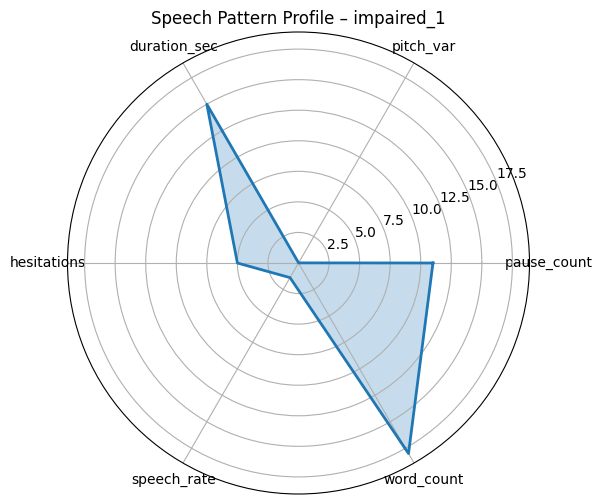

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_radar_chart(df, sample_index):
    features = ['pause_count', 'pitch_var', 'duration_sec', 'hesitations', 'speech_rate', 'word_count']
    labels = df['file'].tolist()
    values = df.loc[sample_index, features].values

    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), features)
    ax.set_title(f"Speech Pattern Profile – {df.loc[sample_index, 'file']}")
    plt.show()

# Example usage:
plot_radar_chart(df, 2)  # Plot for impaired_1


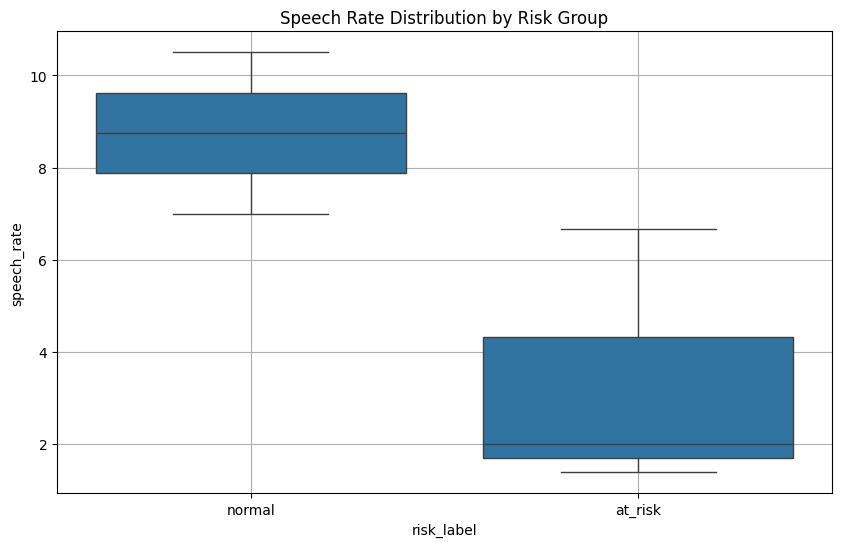

In [10]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='risk_label', y='speech_rate', data=df)
plt.title('Speech Rate Distribution by Risk Group')
plt.grid(True)
plt.show()


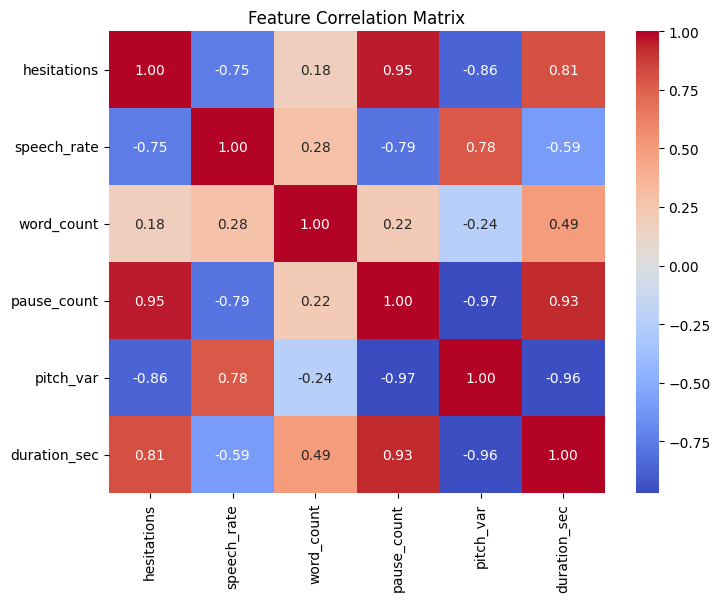

In [11]:
import seaborn as sns

plt.figure(figsize=(8,6))
corr = df.drop(columns=['file', 'transcript', 'risk_label'], errors='ignore').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


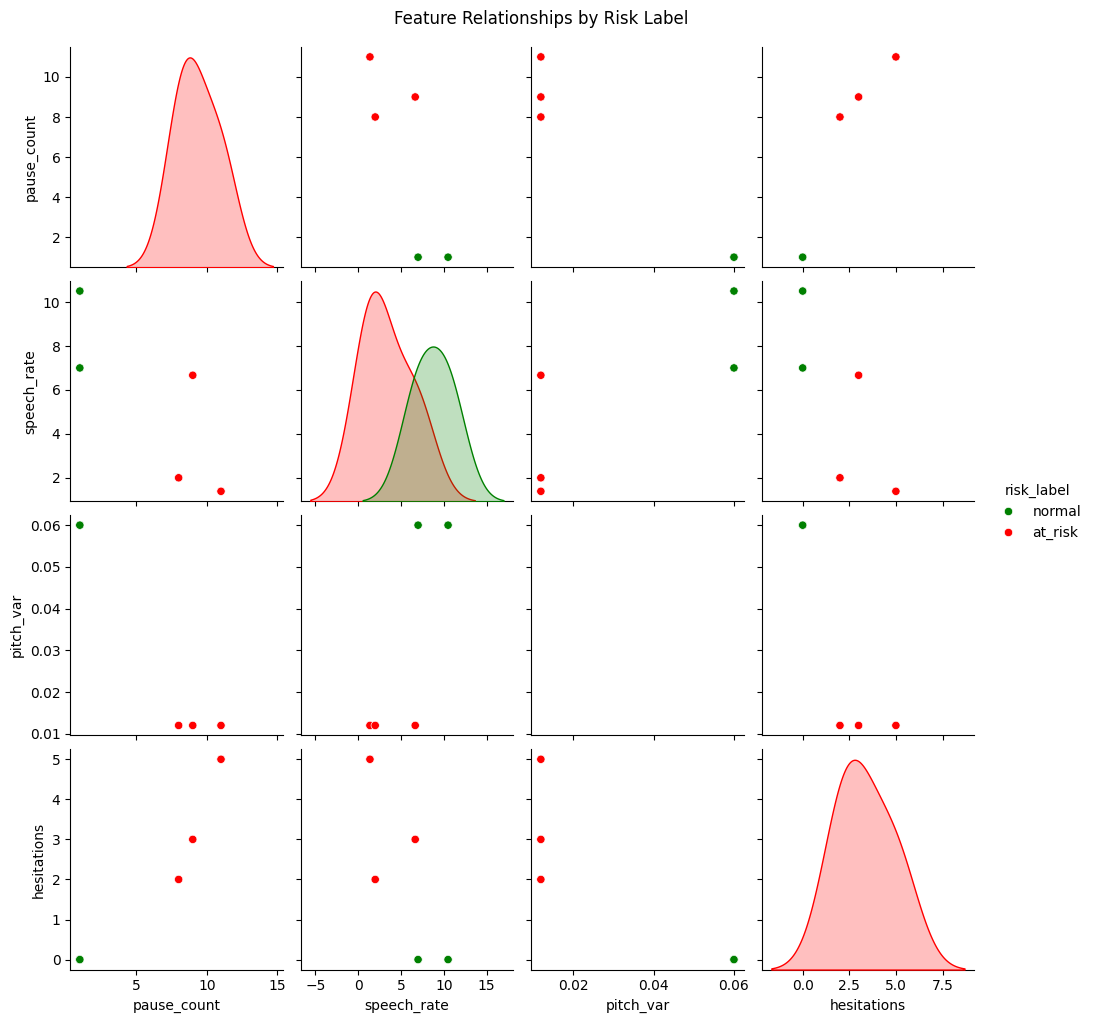

In [12]:
sns.pairplot(df, vars=["pause_count", "speech_rate", "pitch_var", "hesitations"],
             hue="risk_label", palette={"normal": "green", "at_risk": "red"})
plt.suptitle("Feature Relationships by Risk Label", y=1.02)
plt.show()


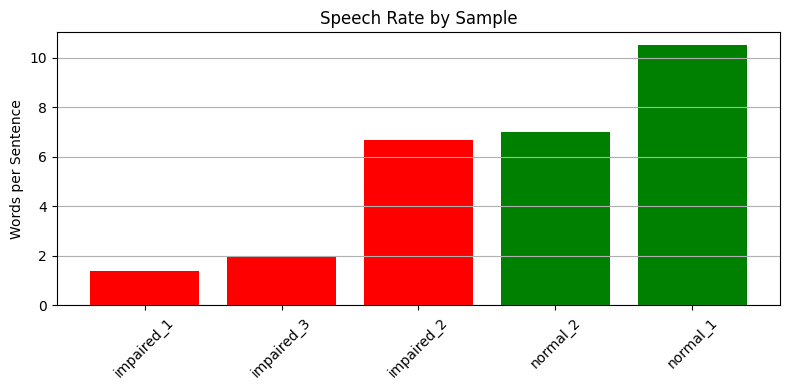

In [13]:
df_sorted = df.sort_values("speech_rate")

plt.figure(figsize=(8, 4))
plt.bar(df_sorted["file"], df_sorted["speech_rate"], color=df_sorted["risk_label"].map({"normal": "green", "at_risk": "red"}))
plt.title("Speech Rate by Sample")
plt.ylabel("Words per Sentence")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


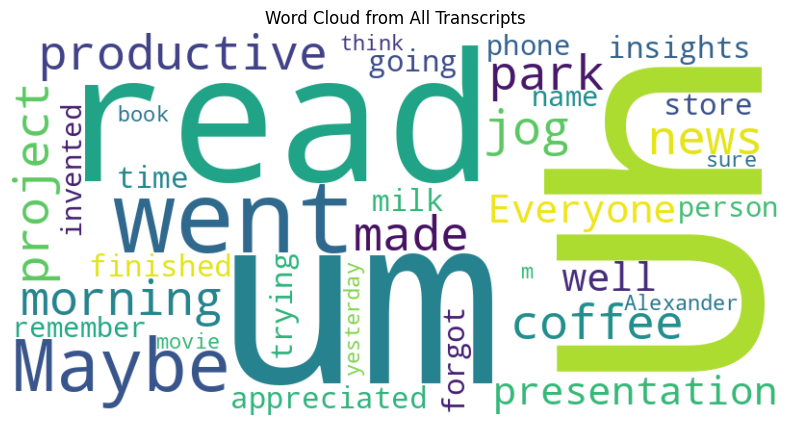

In [14]:
from wordcloud import WordCloud

text = " ".join(df["transcript"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud from All Transcripts")
plt.show()
